In [ ]:
import pandas as pd
import numpy as np
import zipfile
import os
import shutil
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load CSV file containing image IDs and labels
csv_file_id = "1NH-jvwPFytwAJSL_uhlMDLwBI5PHRvJW"
csv_file = drive.CreateFile({'id': csv_file_id})
csv_file.GetContentFile("ISIC-2017_Training_Part3_GroundTruth.csv")

# Load ZIP file containing images
zip_file_id = "1pWLAcNGTcJf8rLp2RIs5BSBvLZovFiCd"
zip_file = drive.CreateFile({'id': zip_file_id})
zip_file.GetContentFile("ISIC-2017_Training_Data.zip")

# Unzip the image data
with zipfile.ZipFile("ISIC-2017_Training_Data.zip", 'r') as zip_ref:
    zip_ref.extractall("extracted_images")

# Preprocess images and create dataset
image_dir = "extracted_images/ISIC-2017_Training_Data"  # Adjusted directory path

# Load CSV file containing image IDs and labels
df = pd.read_csv("ISIC-2017_Training_Part3_GroundTruth.csv")

# Create new directories for melanoma and non-melanoma images
melanoma_dir = "melanoma_images"
non_melanoma_dir = "non_melanoma_images"

os.makedirs(melanoma_dir, exist_ok=True)
os.makedirs(non_melanoma_dir, exist_ok=True)

# Segregate images based on melanoma label
for index, row in df.iterrows():
    img_id = row['image_id']
    img_path = os.path.join(image_dir, img_id + ".jpg")

    # Check if the image file exists
    if not os.path.exists(img_path):
        print("Image file not found:", img_path)
        continue

    # Determine the directory based on the 'melanoma' column
    if row['melanoma'] == 1:
        destination_dir = melanoma_dir
    else:
        destination_dir = non_melanoma_dir

    # Move the image file to the corresponding directory
    shutil.copy(img_path, destination_dir)

print("Images preprocessed successfully.")




Images preprocessed successfully.


In [ ]:
num_melanoma_images = len(os.listdir(melanoma_dir))
num_non_melanoma_images = len(os.listdir(non_melanoma_dir))


# Initialize ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Determine which class has fewer images
if num_non_melanoma_images < num_melanoma_images:
    class_to_augment = non_melanoma_dir
    class_to_balance = melanoma_dir
    augmentation_factor = num_melanoma_images // num_non_melanoma_images
else:
    class_to_augment = melanoma_dir
    class_to_balance = non_melanoma_dir
    augmentation_factor = num_non_melanoma_images // num_melanoma_images

# Perform augmentation for the class with fewer images
class_images = os.listdir(class_to_augment)
for img_file in class_images:
    img_path = os.path.join(class_to_augment, img_file)
    img = Image.open(img_path)
    img = img.convert("RGB")
    img_array = np.array(img)
    img_array = img_array.reshape((1,) + img_array.shape)

    # Generate augmented images with a limit
    num_augmented_images = 0
    for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_to_augment, save_prefix='aug', save_format='jpeg'):
        num_augmented_images += 1
        if num_augmented_images >= augmentation_factor:
            break

print("Images augmented successfully.")







Images augmented successfully.


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use GPU with ID 0

In [ ]:
# List images in melanoma_images directory
print("Images in melanoma_images directory:")
melanoma_images = os.listdir(melanoma_dir)
print(melanoma_images)

# List images in non_melanoma_images directory
print("\nImages in non_melanoma_images directory:")
non_melanoma_images = os.listdir(non_melanoma_dir)
print(non_melanoma_images)

Images in melanoma_images directory:
['aug_0_5259.jpeg', 'aug_0_9922.jpeg', 'aug_0_5187.jpeg', 'aug_0_3902.jpeg', 'aug_0_8645.jpeg', 'ISIC_0009905.jpg', 'ISIC_0000551.jpg', 'aug_0_4371.jpeg', 'ISIC_0000295.jpg', 'aug_0_8195.jpeg', 'aug_0_330.jpeg', 'aug_0_5284.jpeg', 'aug_0_207.jpeg', 'aug_0_5503.jpeg', 'ISIC_0000159.jpg', 'aug_0_5418.jpeg', 'ISIC_0010468.jpg', 'aug_0_5975.jpeg', 'ISIC_0014099.jpg', 'aug_0_6520.jpeg', 'ISIC_0013874.jpg', 'aug_0_6447.jpeg', 'aug_0_5473.jpeg', 'aug_0_8983.jpeg', 'aug_0_8887.jpeg', 'aug_0_1925.jpeg', 'aug_0_6508.jpeg', 'aug_0_4317.jpeg', 'aug_0_6996.jpeg', 'aug_0_9086.jpeg', 'aug_0_8569.jpeg', 'aug_0_6514.jpeg', 'aug_0_7986.jpeg', 'aug_0_905.jpeg', 'aug_0_8708.jpeg', 'aug_0_6981.jpeg', 'aug_0_2875.jpeg', 'ISIC_0010329.jpg', 'ISIC_0013594.jpg', 'aug_0_9950.jpeg', 'aug_0_4079.jpeg', 'aug_0_7766.jpeg', 'aug_0_7102.jpeg', 'aug_0_650.jpeg', 'ISIC_0000150.jpg', 'aug_0_7538.jpeg', 'aug_0_4618.jpeg', 'aug_0_2854.jpeg', 'aug_0_6282.jpeg', 'ISIC_0012450.jpg', 'ISIC

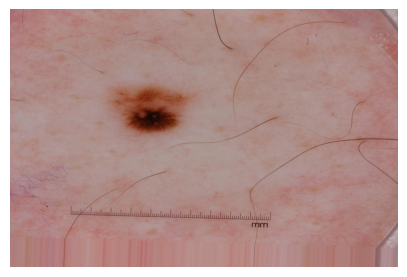

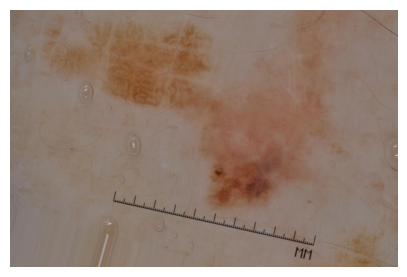

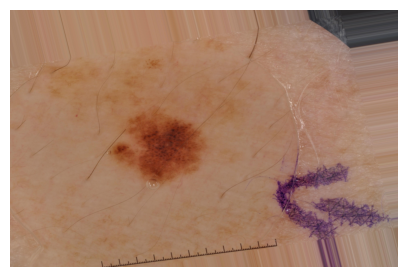

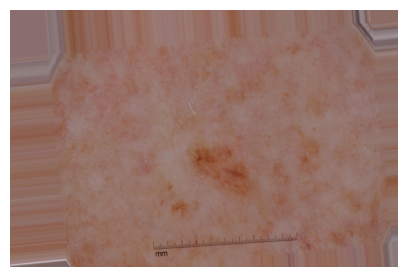

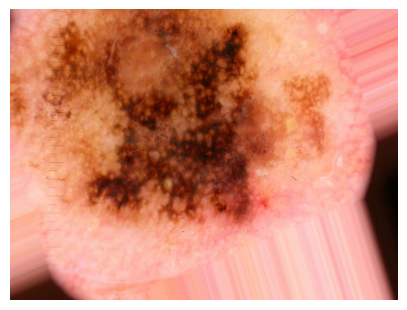

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Path to the directory containing melanoma images
melanoma_dir = "melanoma_images"

# Get list of image files in the directory
image_files = os.listdir(melanoma_dir)

# Display the first 5 images
num_images_to_display = 5
for i in range(num_images_to_display):
    img_path = os.path.join(melanoma_dir, image_files[i])
    img = mpimg.imread(img_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
import os
import shutil
import random

# Define source directories
source_melanoma = 'melanoma_images'
source_non_melanoma = 'non_melanoma_images'

# Define target directories
train_melanoma_dir = 'train_melanoma'
validation_melanoma_dir = 'validation_melanoma'
test_melanoma_dir = 'test_melanoma'

train_non_melanoma_dir = 'train_non_melanoma'
validation_non_melanoma_dir = 'validation_non_melanoma'
test_non_melanoma_dir = 'test_non_melanoma'

# Create target directories
os.makedirs(train_melanoma_dir, exist_ok=True)
os.makedirs(validation_melanoma_dir, exist_ok=True)
os.makedirs(test_melanoma_dir, exist_ok=True)

os.makedirs(train_non_melanoma_dir, exist_ok=True)
os.makedirs(validation_non_melanoma_dir, exist_ok=True)
os.makedirs(test_non_melanoma_dir, exist_ok=True)

# Function to split images
def split_data(source, train, validation, test, split_ratio=(0.6, 0.2, 0.2)):
    files = os.listdir(source)
    random.shuffle(files)
    total_files = len(files)
    train_split = int(total_files * split_ratio[0])
    validation_split = int(total_files * (split_ratio[0] + split_ratio[1]))

    train_files = files[:train_split]
    validation_files = files[train_split:validation_split]
    test_files = files[validation_split:]

    for file in train_files:
        shutil.copy(os.path.join(source, file), os.path.join(train, file))

    for file in validation_files:
        shutil.copy(os.path.join(source, file), os.path.join(validation, file))

    for file in test_files:
        shutil.copy(os.path.join(source, file), os.path.join(test, file))

# Split melanoma images
split_data(source_melanoma, train_melanoma_dir, validation_melanoma_dir, test_melanoma_dir)

# Split non-melanoma images
split_data(source_non_melanoma, train_non_melanoma_dir, validation_non_melanoma_dir, test_non_melanoma_dir)

print("Data split successfully.")

Data split successfully.


In [ ]:
import os
import shutil

# Define the mother directory name
mother_directory = 'train_data'


# Create the mother directory if it doesn't exist
if not os.path.exists(mother_directory):
    os.makedirs(mother_directory)

# Move train_melanoma directory into the mother directory
shutil.move('train_melanoma', os.path.join(mother_directory, 'train_melanoma'))

# Move train_non_melanoma directory into the mother directory
shutil.move('train_non_melanoma', os.path.join(mother_directory, 'train_non_melanoma'))

print("Directories moved successfully.")

Directories moved successfully.


In [ ]:
import os
import shutil

# Define the mother directory names
mother_validation_directory = 'validation_data'
mother_test_directory = 'test_data'

# Create the mother directories if they don't exist
if not os.path.exists(mother_validation_directory):
    os.makedirs(mother_validation_directory)
if not os.path.exists(mother_test_directory):
    os.makedirs(mother_test_directory)

# Move validation_melanoma directory into the mother validation directory
shutil.move('validation_melanoma', os.path.join(mother_validation_directory, 'validation_melanoma'))

# Move validation_non_melanoma directory into the mother validation directory
shutil.move('validation_non_melanoma', os.path.join(mother_validation_directory, 'validation_non_melanoma'))

# Move test_melanoma directory into the mother test directory
shutil.move('test_melanoma', os.path.join(mother_test_directory, 'test_melanoma'))

# Move test_non_melanoma directory into the mother test directory
shutil.move('test_non_melanoma', os.path.join(mother_test_directory, 'test_non_melanoma'))

print("Directories moved successfully.")

Directories moved successfully.


MODEL 1: INCEPTION V3

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 299, 299  # InceptionV3 input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load InceptionV3 base model
base_model = InceptionV3(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")







Found 2038 images belonging to 2 classes.
Found 680 images belonging to 2 classes.
Found 681 images belonging to 2 classes.
Epoch 1/50
64/64 [==============================] - 190s 3s/step - loss: 0.6767 - accuracy: 0.6286 - val_loss: 0.5222 - val_accuracy: 0.7485
Epoch 2/50
64/64 [==============================] - 185s 3s/step - loss: 0.5548 - accuracy: 0.7130 - val_loss: 0.5335 - val_accuracy: 0.7176
Epoch 3/50
64/64 [==============================] - 180s 3s/step - loss: 0.5251 - accuracy: 0.7267 - val_loss: 0.4571 - val_accuracy: 0.7853
Epoch 4/50
64/64 [==============================] - 189s 3s/step - loss: 0.4923 - accuracy: 0.7610 - val_loss: 0.4371 - val_accuracy: 0.7765
Epoch 5/50
64/64 [==============================] - 188s 3s/step - loss: 0.4754 - accuracy: 0.7581 - val_loss: 0.4433 - val_accuracy: 0.7912
Epoch 6/50
64/64 [==============================] - 190s 3s/step - loss: 0.4657 - accuracy: 0.7704 - val_loss: 0.4468 - val_accuracy: 0.7824
Epoch 7/50
64/64 [============

Confusion Matrix:
[[288  67]
 [ 48 278]]


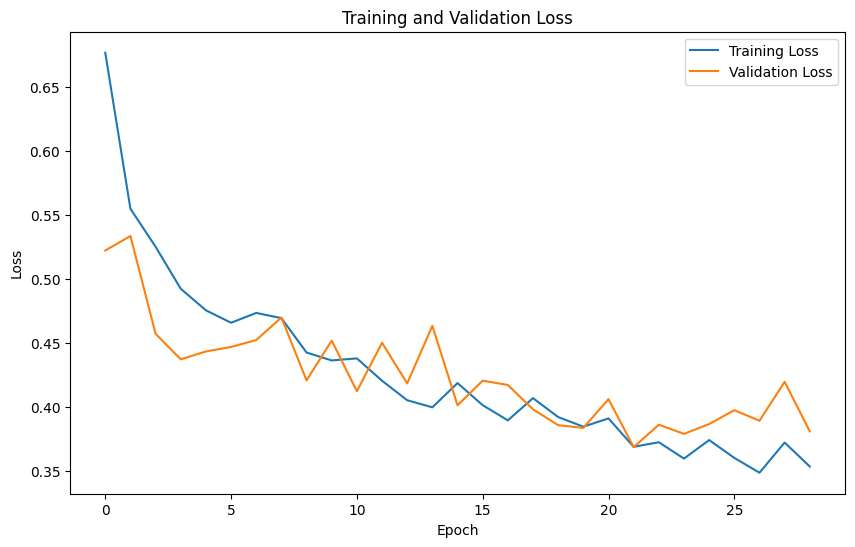

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

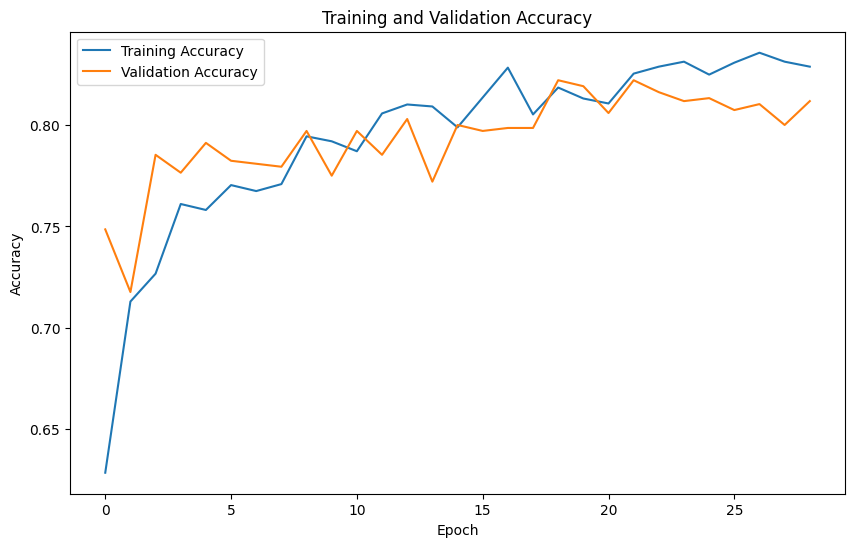

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

MOBILENET : MODEL 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 224, 224  # MobileNet input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load MobileNet base model
base_model = MobileNet(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")





Found 2038 images belonging to 2 classes.
Found 680 images belonging to 2 classes.
Found 681 images belonging to 2 classes.
17225924/17225924 [==============================] - 1s 0us/step
Epoch 1/50
64/64 [==============================] - 177s 3s/step - loss: 0.6110 - accuracy: 0.6874 - val_loss: 0.4466 - val_accuracy: 0.7882
Epoch 2/50
64/64 [==============================] - 172s 3s/step - loss: 0.4935 - accuracy: 0.7488 - val_loss: 0.4372 - val_accuracy: 0.7985
Epoch 3/50
64/64 [==============================] - 171s 3s/step - loss: 0.4428 - accuracy: 0.7821 - val_loss: 0.4445 - val_accuracy: 0.7735
Epoch 4/50
64/64 [==============================] - 171s 3s/step - loss: 0.4231 - accuracy: 0.7974 - val_loss: 0.3947 - val_accuracy: 0.8132
Epoch 5/50
64/64 [==============================] - 168s 3s/step - loss: 0.3919 - accuracy: 0.8165 - val_loss: 0.4144 - val_accuracy: 0.7941
Epoch 6/50
64/64 [==============================] - 175s 3s/step - loss: 0.3796 - accuracy: 0.8229 - val_l

Confusion Matrix:
[[321  34]
 [ 59 267]]


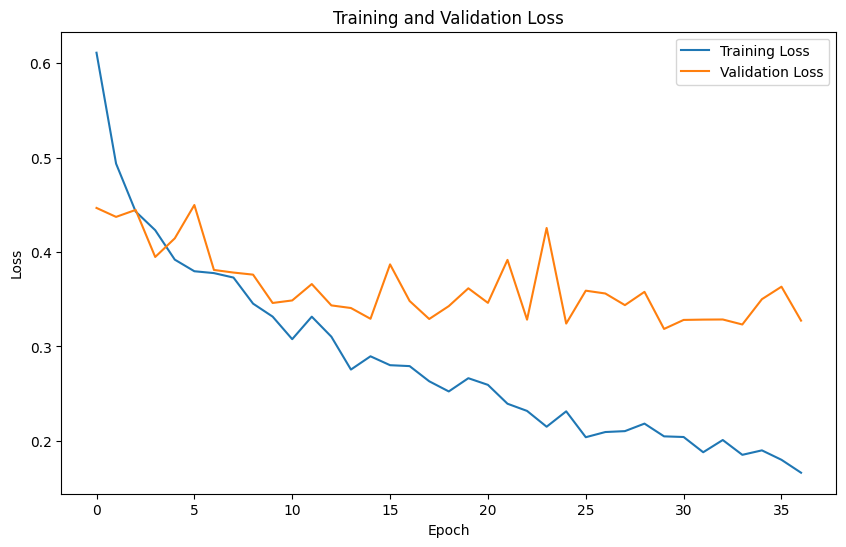

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

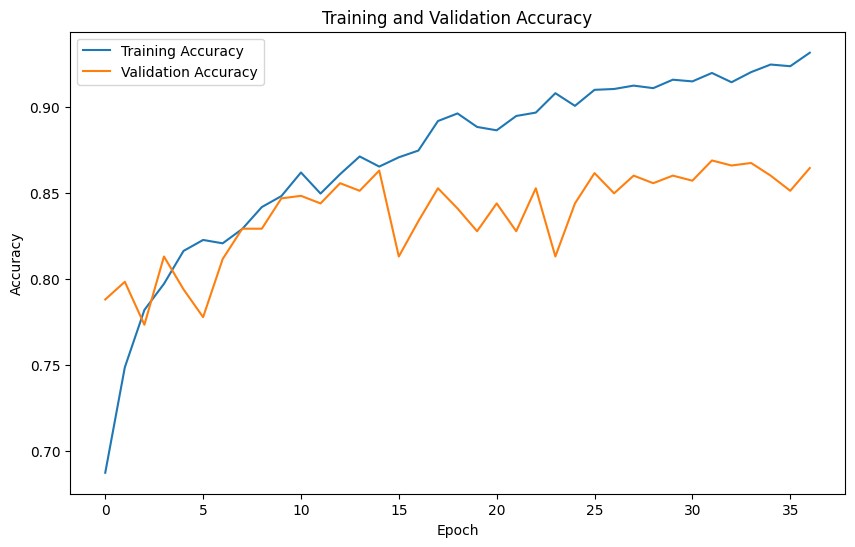

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
accuracy = accuracy_score(true_classes, predicted_classes)

print("\nTest Set Metrics:")
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

_, train_acc = model.evaluate(train_generator)
print("\nTraining Set Metrics:")
print(f'Training Accuracy: {train_acc}')


Test Set Metrics:
Accuracy: 0.8634361233480177
Precision: 0.8649892197967514
Recall: 0.8634361233480177
F1 Score: 0.8630360729330622
64/64 [==============================] - 126s 2s/step - loss: 0.1670 - accuracy: 0.9352

Training Set Metrics:
Training Accuracy: 0.9352306127548218


In [ ]:
# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=train_generator.class_indices)
print(report)

                    precision    recall  f1-score   support

    train_melanoma       0.84      0.90      0.87       355
train_non_melanoma       0.89      0.82      0.85       326

          accuracy                           0.86       681
         macro avg       0.87      0.86      0.86       681
      weighted avg       0.86      0.86      0.86       681



MODEL 3: EFFICIENT NET B0

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 224, 224  # EfficientNetB0 input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load EfficientNetB0 base model
base_model = EfficientNetB0(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")



Found 2038 images belonging to 2 classes.
Found 680 images belonging to 2 classes.
Found 681 images belonging to 2 classes.
Epoch 1/50
64/64 [==============================] - 178s 3s/step - loss: 0.7085 - accuracy: 0.5044 - val_loss: 0.6946 - val_accuracy: 0.5221
Epoch 2/50
64/64 [==============================] - 168s 3s/step - loss: 0.6940 - accuracy: 0.5221 - val_loss: 0.6930 - val_accuracy: 0.5221
Epoch 3/50
64/64 [==============================] - 167s 3s/step - loss: 0.6928 - accuracy: 0.5329 - val_loss: 0.6934 - val_accuracy: 0.4779
Epoch 4/50
64/64 [==============================] - 168s 3s/step - loss: 0.6937 - accuracy: 0.5088 - val_loss: 0.6923 - val_accuracy: 0.5221
Epoch 5/50
64/64 [==============================] - 169s 3s/step - loss: 0.6928 - accuracy: 0.5216 - val_loss: 0.6923 - val_accuracy: 0.5221
Epoch 6/50
64/64 [==============================] - 167s 3s/step - loss: 0.6924 - accuracy: 0.5216 - val_loss: 0.6922 - val_accuracy: 0.5221
Epoch 7/50
64/64 [============

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Confusion Matrix:
[[355   0]
 [326   0]]


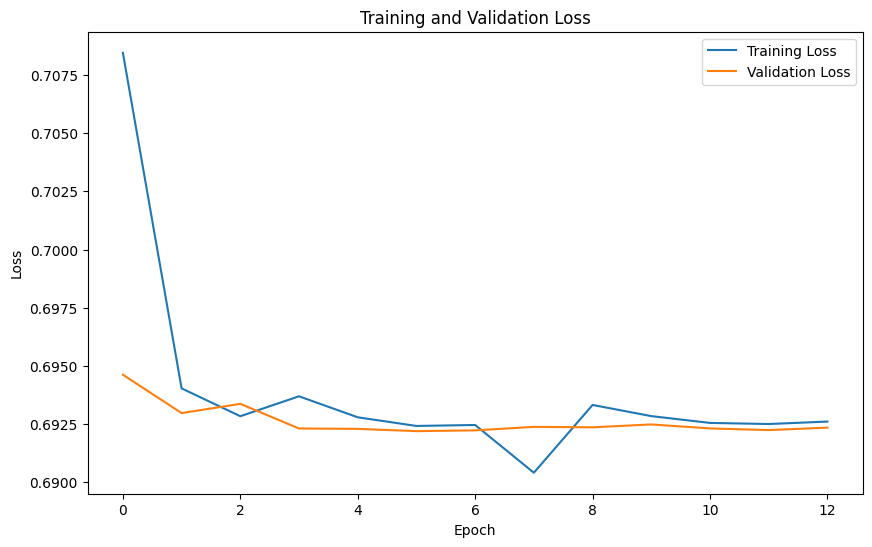

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

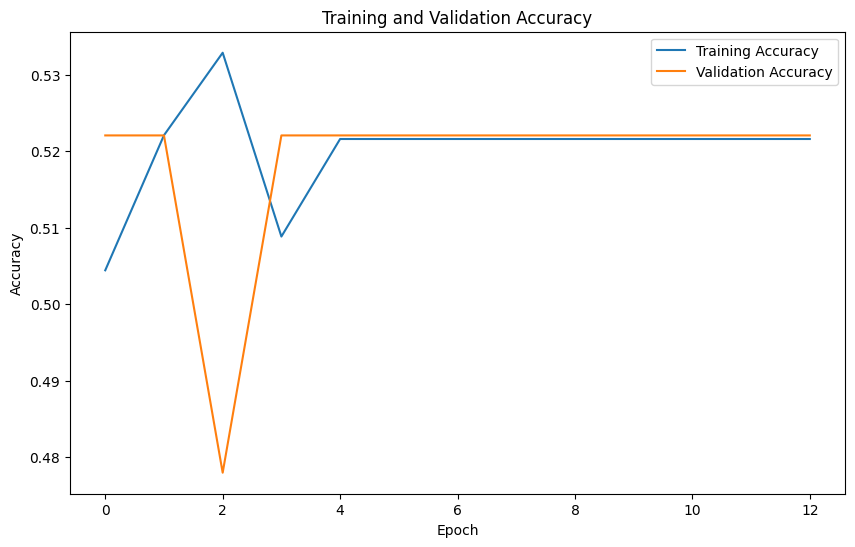

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

MODEL 4: XCEPTION

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 224, 224  # MobileNet input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load MobileNet base model
base_model = MobileNet(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")





Found 2028 images belonging to 2 classes.
Found 676 images belonging to 2 classes.
Found 677 images belonging to 2 classes.
17225924/17225924 [==============================] - 1s 0us/step
Epoch 1/50
64/64 [==============================] - 168s 3s/step - loss: 0.6634 - accuracy: 0.6627 - val_loss: 0.4710 - val_accuracy: 0.7988
Epoch 2/50
64/64 [==============================] - 165s 3s/step - loss: 0.5132 - accuracy: 0.7480 - val_loss: 0.4491 - val_accuracy: 0.7885
Epoch 3/50
64/64 [==============================] - 165s 3s/step - loss: 0.4724 - accuracy: 0.7742 - val_loss: 0.4205 - val_accuracy: 0.8018
Epoch 4/50
64/64 [==============================] - 166s 3s/step - loss: 0.4215 - accuracy: 0.8018 - val_loss: 0.4046 - val_accuracy: 0.8077
Epoch 5/50
64/64 [==============================] - 166s 3s/step - loss: 0.4126 - accuracy: 0.8033 - val_loss: 0.4000 - val_accuracy: 0.8121
Epoch 6/50
64/64 [==============================] - 165s 3s/step - loss: 0.3942 - accuracy: 0.8176 - val_l

Confusion Matrix:
[[312  39]
 [ 48 278]]


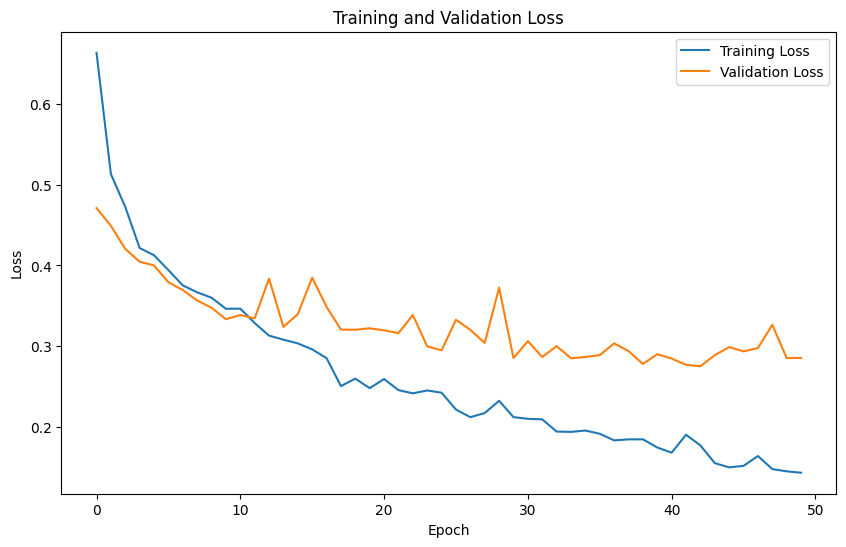

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

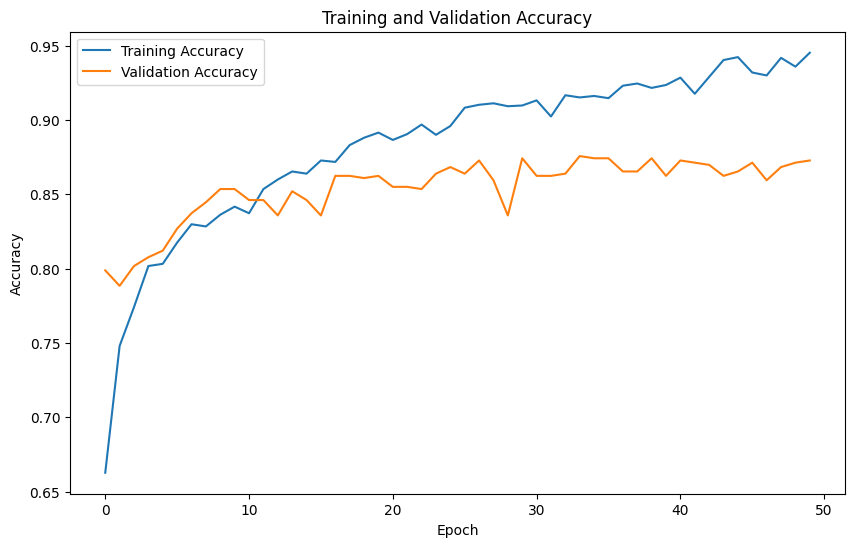

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

MODEL 5: DENSENET 121

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 224, 224  # DenseNet121 input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load DenseNet121 base model
base_model = DenseNet121(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")



Found 2028 images belonging to 2 classes.
Found 676 images belonging to 2 classes.
Found 677 images belonging to 2 classes.
29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/50
64/64 [==============================] - 179s 3s/step - loss: 0.6272 - accuracy: 0.6514 - val_loss: 0.4697 - val_accuracy: 0.7988
Epoch 2/50
64/64 [==============================] - 164s 3s/step - loss: 0.5366 - accuracy: 0.7209 - val_loss: 0.4549 - val_accuracy: 0.7840
Epoch 3/50
64/64 [==============================] - 164s 3s/step - loss: 0.5076 - accuracy: 0.7421 - val_loss: 0.4396 - val_accuracy: 0.8018
Epoch 4/50
64/64 [==============================] - 165s 3s/step - loss: 0.4698 - accuracy: 0.7613 - val_loss: 0.4488 - val_accuracy: 0.7944
Epoch 5/50
64/64 [==============================] - 163s 3s/step - loss: 0.4446 - accuracy: 0.7825 - val_loss: 0.4405 - val_accuracy: 0.8018
Epoch 6/50
64/64 [==============================] - 165s 3s/step - loss: 0.4307 - accuracy: 0.8037 - val_l

Confusion Matrix:
[[299  52]
 [ 58 268]]


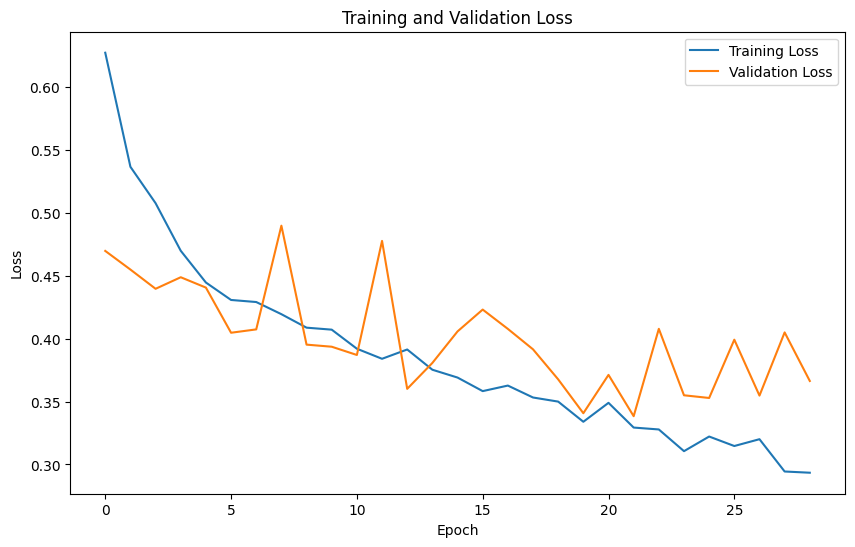

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

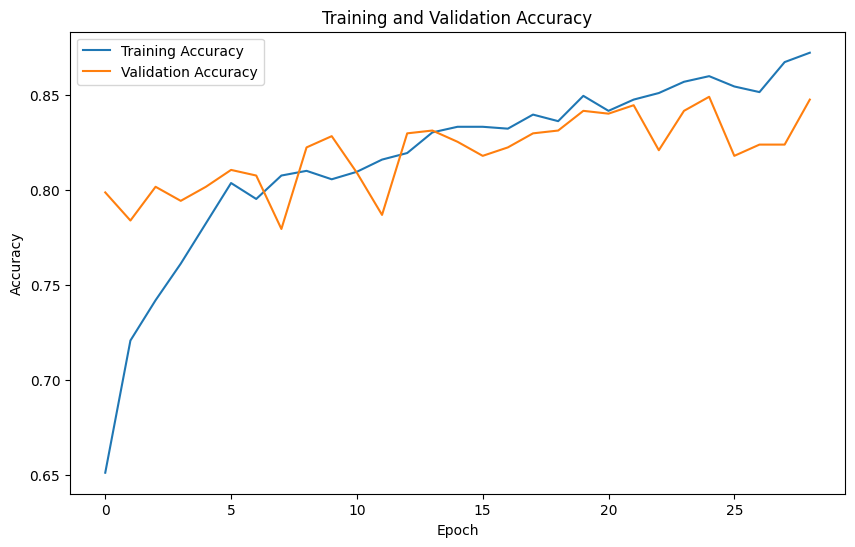

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

MODEL 6: NASNETLARGE

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 331, 331  # NASNetLarge input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load NASNetLarge base model
base_model = NASNetLarge(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")



Found 2028 images belonging to 2 classes.
Found 676 images belonging to 2 classes.
Found 677 images belonging to 2 classes.
343610240/343610240 [==============================] - 13s 0us/step
Epoch 1/50
64/64 [==============================] - 226s 3s/step - loss: 0.5599 - accuracy: 0.7012 - val_loss: 0.4821 - val_accuracy: 0.7707
Epoch 2/50
64/64 [==============================] - 198s 3s/step - loss: 0.4757 - accuracy: 0.7599 - val_loss: 0.4108 - val_accuracy: 0.8107
Epoch 3/50
64/64 [==============================] - 196s 3s/step - loss: 0.4501 - accuracy: 0.7825 - val_loss: 0.3902 - val_accuracy: 0.8092
Epoch 4/50
64/64 [==============================] - 197s 3s/step - loss: 0.4351 - accuracy: 0.7939 - val_loss: 0.3873 - val_accuracy: 0.8092
Epoch 5/50
64/64 [==============================] - 196s 3s/step - loss: 0.4034 - accuracy: 0.8131 - val_loss: 0.3684 - val_accuracy: 0.8166
Epoch 6/50
64/64 [==============================] - 197s 3s/step - loss: 0.3808 - accuracy: 0.8215 - va

Confusion Matrix:
[[295  56]
 [ 35 291]]


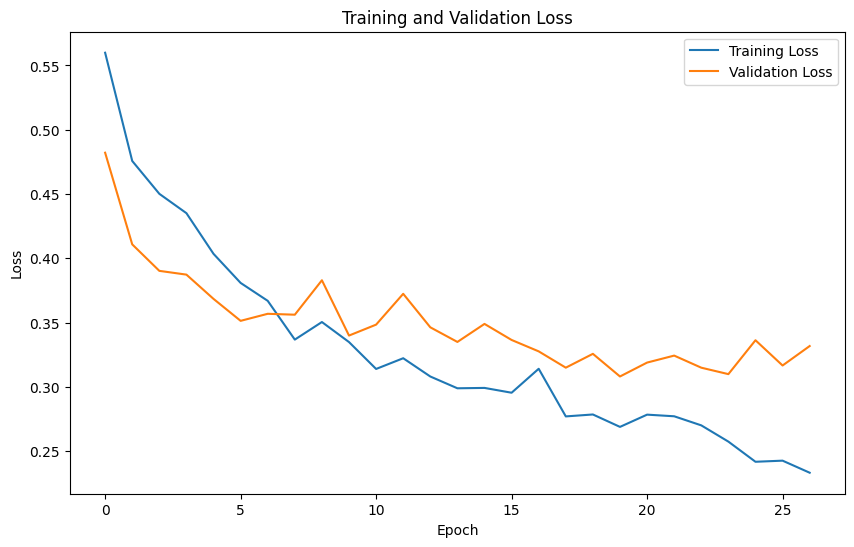

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

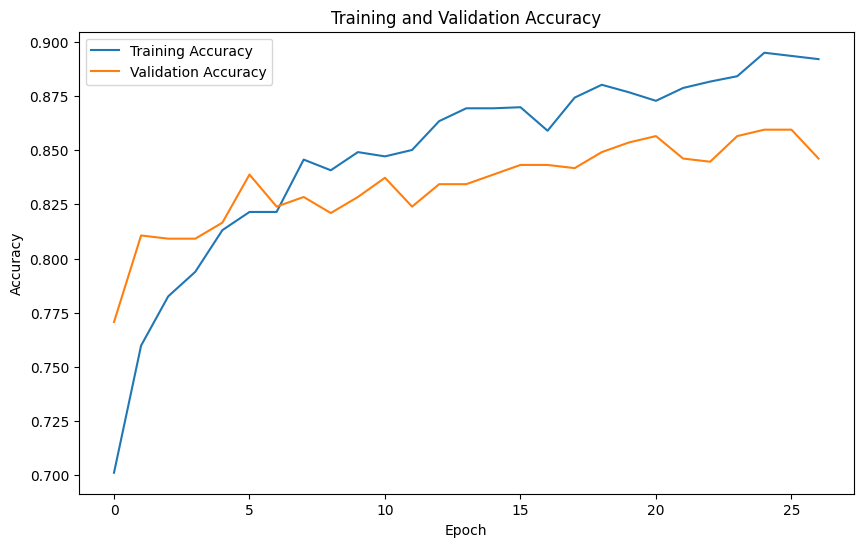

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()